# Quora Duplicate Questions Classification Task

Quora is a question/answer website where users can ask and answer questions about anything. To improve the website for users, Quora wants to remove duplicate questions, so users are always directed to the one definitive page for that question. Zero percent duplication is unlikely, but automated 

To help with this goal, Quora has released a data set of ~400,000 question pairs from Quora, where each pair is marked as being either a duplicate or a non-duplicate. Release statement and data found here: https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs

For example, 

#### "How do you start a bakery?" and "How does one start a bakery business?" 

are labelled as duplicates, but 

#### "Does society place too much importance on sports?" and "How do sports contribute to the society?"

are not. The labeling itself was done by humans, so reasonable people may disagree about some of them - such label noise is a fact of life for many classification tasks. 

The classification goal is to predict whether each question pair is labelled as duplicates or not. 

It is important to consider how the model will be used to know what metrics to optimize. For example, it is not necessarily true that we want a model that is as accurate as possible: if the model will lead to automatic deletion of one of the posts marked "duplicate", it may be more important to avoid falsely labeling different posts as duplicates (false positives) than to miss marking true duplicates as duplicates (false negatives). These considerations are why precision the precision and recall of a classification model are important to consider in addition to its accuracy. 

# Data Cleaning

It's always a good idea to check data set for missing values, unusual values, unusual data types, etc. Since this is a prepared data set released by a company it should be pretty well-formed already, but it's good practice to check anyway. It's also good to constantly be looking at examples of data to understand better what your model must accomplish.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("quora_duplicate_questions.tsv", sep='\t')

In [3]:
len(data)

404290

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id           404290 non-null int64
qid1         404290 non-null int64
qid2         404290 non-null int64
text1        404290 non-null object
text2        404288 non-null object
duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
type(data.text1[0])

str

In [6]:
# find if any rows have null values 
data[data.isnull().any(axis=1)]

,id,qid1,qid2,text1,text2,duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [7]:
# delete rows that contain null values
data.dropna(inplace=True)

In [8]:
# useful command that lets us see full string in columns; otherwise string is truncated 
# as in data.head() above
pd.options.display.max_colwidth = -1

Let's take a look at some of actual question comparisons. 

In [9]:
data[["text1", "text2", "duplicate"]].head()

,text1,text2,duplicate
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In looking at data I notice a few things: 

#### 1) There can be reasonable disagreement about whether questions are duplicates. 

For example, at index 19, "Why do rockets look white?" could be considered slightly different from "Why are rockets and boosters painted white" - in fact, the answer to the first question might be "because they are painted white" (as opposed to something like "atmospheric effects make them look white during liftoff"), which might naturally lead to the second question. In thise dataset though, these questions are considered duplicates. This type of "reasonable disagreement noise" in labeling is common, unavoidable, and important to be aware of.

#### 2) For questions that are not considered duplicates, there appear to be two classes: ones where the two questions are closely related but distinct, and ones where the two questions are totally unrelated.

For example, at index 0 the questions "What is the step by step guide to invest in share market in India?" and "What is the step by step guide to invest in share market?" are closely related but logically distinct, as one has a narrower focus than the other. However, at index 3 we have 

"Why am I mentally very lonely? How can I solve it?" 

being compared with 

"Find the remainder when [math]23^{24}[/math] is divided by 24,23?"

which are completely unrelated. This is likely due to the sampling issue mentioned in data release: 

"Our original sampling method returned an imbalanced dataset with many more true examples of duplicate pairs than non-duplicates. Therefore, we supplemented the dataset with negative examples. One source of negative examples were pairs of “related questions” which, although pertaining to similar topics, are not truly semantically equivalent."

This is useful to know for model creation, as we now know we cannot assume the two questions will be somewhat related - they could be completely different. 

## Baseline model

Always a good idea to try an extremely simple model first. This helps set a baseline for what is considered a "good" model.

For this data set, the simplest conceivable model would be to predict whichever class is most common in the data.

This model predicts every item as "not duplicate" and gets 63% accuracy. It also has virtue of not falsely predicting any true different posts as duplicates (i.e., no false positives), which is probably a particularly important characteristic for a model used in production.

In [10]:
print "Number of 0 labels:", len(data[data.duplicate == 0])
print "Number of 1 labels:", len(data[data.duplicate == 1])
print "Accuracy to predict most common label (in this case 0):", len(data[data.duplicate == 0])/float(len(data))

Number of 0 labels: 255025
Number of 1 labels: 149263
Accuracy to predict most common label (in this case 0): 0.630800320564


# Create features

For text data, a common feature set is weighted term frequenices. Each text document is then represented as a tf-idf vector, which uses word frequencies between documents (normalized by how often the words appear across documents) as features. 

The sklearn implementation provides options to remove "stop words" (common english words like "the" that are unlikely to communicate information content), remove words that appear too frequently or too rarely, and to select how many words total should be considered features when building a feature vector. It also has ability to extract N-grams, which help preserve some of ordering information that a regular frequency count completely loses.

Because the classification task involves comparing two documents (in this case two questions), we will need a way to compare the two feature vectors. The standard way to do this for documents is to compute the dot product between their tf-idf vectors, called the cosine similarity. The sklearn tf-idf vectors are normalized to unit length already, so we can use a regular dot product without dividing by vectors lengths.  

### Feature ideas: 

0) explore distribution of dot products between questions for each feature idea

0.5) use hashing trick for feature vector creation to increase speed if don't need to convert vectors back to words

1) cross-validate to test parameters for max_df, min_df, and max_features

2) binary occurence model (instead of tf-idf - supposed to be better for small documents)

## TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, max_df=0.5)

In [12]:
# make dataframe with one column for all questions so they shared same vocabulary in 
# word frequency model
all_questions = pd.concat([data["text1"], data["text2"]], ignore_index=True)

In [13]:
# vectorize all questions together for one common vocabulary and feature space
all_Q = vectorizer.fit_transform(all_questions.values)

In [14]:
all_Q.shape[0]

808576

In [15]:
Q1 = all_Q[0:all_Q.shape[0]/2]
Q2 = all_Q[all_Q.shape[0]/2:]

In [16]:
print "Q1 shape:", Q1.shape
print "Q2 shape:", Q2.shape

Q1 shape: (404288, 85846)
Q2 shape: (404288, 85846)


Below shows how we can use the tf-idf vector to go back to word representation (though with order information lost). 

In [17]:
import numpy as np
# gives list of features in alphabetical order
word_bank = np.array(vectorizer.get_feature_names())

In [18]:
for index in Q1[0,:].nonzero()[1]:
    print word_bank[index]

step
guide
invest
share
market
india


In [19]:
for index in Q2[0,:].nonzero()[1]:
    print word_bank[index]

step
guide
invest
share
market


Next show how to take a dot product between two sparse vectors. 

The .T takes transpose and .A converts back to a regular numpy array.

In [20]:
row = Q1[0,:]

In [21]:
np.dot(row, row.T).A[0,0]

1.0000000000000002

In [22]:
# try dotting first question from Q1 and Q2 together - very nearly 1, showing related question, 
# tho they are not considered duplicates
np.dot(Q1[0,:], Q2[0,:].T).A[0,0]

0.98178420718145643

In [23]:
# now try dotting two unrelated questions together - zero, as expected 
np.dot(Q1[0,:], Q2[4,:].T).A[0,0]

0.0

In [24]:
# lastly, try dot between two questions (index 5) that are considered duplicates: 
# only 0.48, which suggests a model based only on term counts or term frequencies will have 
# trouble achieving high accuracy
np.dot(Q1[5,:], Q2[5,:].T).A[0,0]

0.48180514623932036

### Add tf-idf vectors products to dataframe

In [25]:
# make columns of dots between Q1 and Q2
tf_idf_dot_column = [np.dot(Q1[i,:], Q2[i,:].T).A[0,0] for i in range(Q1.shape[0])]

In [26]:
tf_idf_dot_products = pd.Series(np.array(tf_idf_dot_column))

In [27]:
len(tf_idf_dot_products)

404288

In [28]:
data.reset_index(drop=True, inplace=True)

In [29]:
data = data.assign(tf_idf_dot_products=tf_idf_dot_products.values)

In [30]:
data.head()

,id,qid1,qid2,text1,text2,duplicate,tf_idf_dot_products
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,0.981784
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,0.791940
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,0.276089
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,0.243643


##### Plot tf_idf dot products for duplicates and non-duplicates

We see from charts below that non-duplicates have a spike at 0 and duplicates have a spike at 1, as expected. There appears to be a vast overlap in the middle (meaning in the area where questions use some of the same words), which will be the hardest pairs to correctly classify under this model.

In [31]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

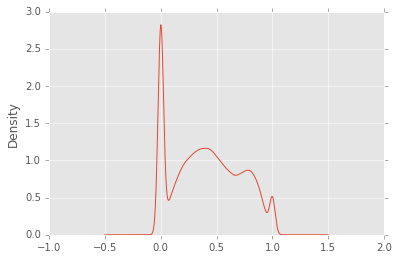

In [32]:
# dot product distribution for non-duplicates
data[data.duplicate == 0].tf_idf_dot_products.plot("kde")

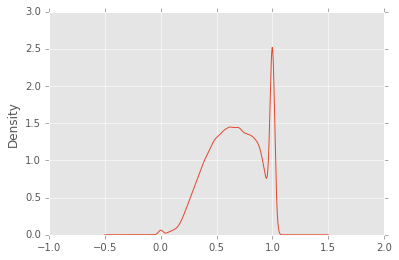

In [33]:
# dot product distribution for duplicates
data[data.duplicate == 1].tf_idf_dot_products.plot("kde")

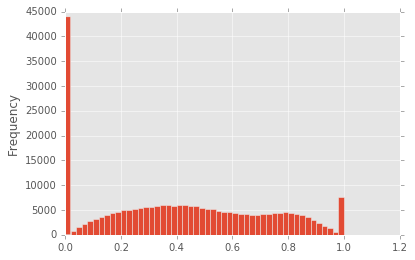

In [34]:
# histograms make this more clear: non-duplicates have a big spike at zero overlap
data[data.duplicate == 0].tf_idf_dot_products.plot("hist", bins=50)

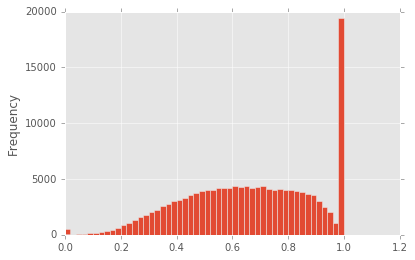

In [35]:
# true duplicates have a big spike at near-total overlap
data[data.duplicate == 1].tf_idf_dot_products.plot("hist", bins=50)

# Make simple with tf-idf dot products, show ROC plot

In [36]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [37]:
X = data.tf_idf_dot_products.values
y = data.duplicate.values
X = X.reshape(-1,1) # numpy will require features to have this shape in future 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

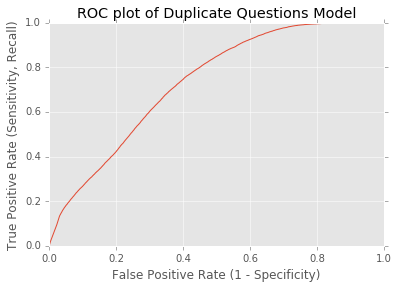

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, X_test)
plt.plot(fpr, tpr) 
plt.xlabel("False Positive Rate (1 - Specificity)") 
plt.ylabel("True Positive Rate (Sensitivity, Recall)") 
plt.title("ROC plot of Duplicate Questions Model")

In [39]:
# compute auc score
roc_auc_score(y_test, X_test)

0.7324474760766857

# Try 2-grams with tf-idf

In [40]:
vectorizer_2gram = TfidfVectorizer(stop_words='english', use_idf=True, max_df=0.5, ngram_range=(1, 2))

In [41]:
# make dataframe with one column for all questions so they shared same vocabulary in 
# word frequency model
all_questions = pd.concat([data["text1"], data["text2"]], ignore_index=True)
# vectorize all questions together for one common vocabulary and feature space
all_Q = vectorizer_2gram.fit_transform(all_questions.values)

In [42]:
Q1 = all_Q[0:all_Q.shape[0]/2]
Q2 = all_Q[all_Q.shape[0]/2:]

In [43]:
# make columns of dots between Q1 and Q2 - this takes about 15 minutes to run
tf_idf_2gram_dot_column = [np.dot(Q1[i,:], Q2[i,:].T).A[0,0] for i in range(Q1.shape[0])]

In [44]:
tf_idf_2gram_dot_products = pd.Series(np.array(tf_idf_2gram_dot_column))
data.reset_index(drop=True, inplace=True)
data = data.assign(tf_idf_2gram_dot_products=tf_idf_2gram_dot_products.values)

In [45]:
data.head()

,id,qid1,qid2,text1,text2,duplicate,tf_idf_dot_products,tf_idf_2gram_dot_products
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,0.981784,0.940753
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,0.791940,0.672595
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,0.276089,0.095180
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,0.243643,0.092756


In [46]:
# plot ROC curve for 2-gram dot products
X = data.tf_idf_2gram_dot_products.values
y = data.duplicate.values
X = X.reshape(-1,1) # numpy will require features to have this shape in future 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

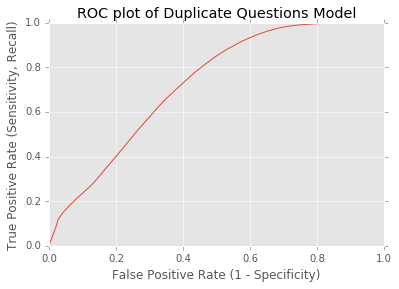

In [47]:
fpr, tpr, thresholds = roc_curve(y, X)
plt.plot(fpr, tpr) 
plt.xlabel("False Positive Rate (1 - Specificity)") 
plt.ylabel("True Positive Rate (Sensitivity, Recall)") 
plt.title("ROC plot of Duplicate Questions Model")

In [48]:
# compute auc score for 2gram model - it's worse than 1-gram!
roc_auc_score(y_test, X_test)

0.72576982770135468

# Word Embeddings with Gensim - see other notebook for more detail

Here we'll need to do some preprocessing on words - we'll lowercase everything and remove punctuation, and make text file that contains a different question on each line. 

## Write cleaned questions to txt files

In [49]:
import gensim # this version is able to use pre-loaded word embeddings for doc2vec
import string

In [70]:
data

,id,qid1,qid2,text1,text2,duplicate,tf_idf_dot_products,tf_idf_2gram_dot_products,cleaned_q1,cleaned_q2
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,0.981784,0.940753,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market in india
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,0.791940,0.672595,what is the story of kohinoor kohinoor diamond,what is the story of kohinoor kohinoor diamond
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,0.276089,0.095180,how can i increase the speed of my internet connection while using a vpn,how can i increase the speed of my internet connection while using a vpn
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,0.000000,0.000000,why am i mentally very lonely how can i solve it,why am i mentally very lonely how can i solve it
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,0.243643,0.092756,which one dissolve in water quikly sugar salt methane and carbon di oxide,which one dissolve in water quikly sugar salt methane and carbon di oxide
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1,0.481805,0.319234,astrology i am a capricorn sun cap moon and cap risingwhat does that say about me,astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0,0.000000,0.000000,should i buy tiago,should i buy tiago
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.832588,0.414926,how can i be a good geologist,how can i be a good geologist
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,1.000000,1.000000,when do you use シ instead of し,when do you use シ instead of し
9,9,19,20,Motorola (company): Can I hack my Charter Motorolla DCX3400?,How do I hack Motorola DCX3400 for free internet?,0,0.631601,0.248232,motorola company can i hack my charter motorolla dcx3400,motorola company can i hack my charter motorolla dcx3400


In [71]:
# lowercase words, remove punctuation and print to text file to prepare for learning
# (sklearn did that automatically with the vectorizer function for tf-idf)
data["cleaned_q1"] = data.text1.str.lower()
data["cleaned_q2"] = data.text2.str.lower()

# remove punctuation
data['cleaned_q1'] = data['cleaned_q1'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
data['cleaned_q2'] = data['cleaned_q2'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [72]:
# remove the character "\n", which messed up the line delimiters in txt file
# these only occur a few times in the questions
data["cleaned_q1"] = data['cleaned_q1'].str.replace("\n", "")
data["cleaned_q2"] = data['cleaned_q2'].str.replace("\n", "")

In [73]:
data["cleaned_q1"].to_csv("cleaned_q1_bow.txt", sep='\n', header=False, index=False)
data["cleaned_q2"].to_csv("cleaned_q2_bow.txt", sep='\n', header=False, index=False)

In [74]:
# write file giving true values for whether questions are duplicates or not
data["duplicate"].to_csv("is_duplicate_bow.txt", sep='\n', header=False, index=False)

In [75]:
%mkdir cleaned_data_bow

In [76]:
%mv cleaned_q1_bow.txt cleaned_data_bow/cleaned_q1_bow.txt

In [77]:
%mv cleaned_q2_bow.txt cleaned_data_bow/cleaned_q2_bow.txt

In [52]:
len(data)

404288

Execute these next cells only if you want to have smaller data set to play with for faster experimentation.

In [ ]:
data[0:10]["cleaned_q1"].to_csv("test_q1.txt", sep='\n', header=False, index=False)
data[0:10]["cleaned_q2"].to_csv("test_q2.txt", sep='\n', header=False, index=False)

In [ ]:
data[0:10]["is_duplicate"].to_csv("test_is_duplicate.txt", sep='\n', header=False, index=False)

In [ ]:
# print sample of 20% of data to use for tuning hyperparameters
data_sample = data.sample(frac=.20, axis=0)

In [ ]:
data_sample["cleaned_q1"].to_csv("20percent_q1.txt", sep='\n', header=False, index=False)
data_sample["cleaned_q2"].to_csv("20percent_q2.txt", sep='\n', header=False, index=False)
data_sample["is_duplicate"].to_csv("20percent_is_dup.txt", sep='\n', header=False, index=False)

## First try training on questions themselves as corpus to generate word vectors

In [78]:
# create iterator to iterate over questions in memory-friendly way, as per word2vec gensim tutorial here: 
# https://rare-technologies.com/word2vec-tutorial/
import os

# iterates over all files ina directory
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()

# class to iterate through single file 
class OneFileSentences(object): 
    def __init__(self, filename): 
        self.filename = filename
    
    def __iter__(self): 
        for line in open(self.filename): 
            yield line.split()

In [79]:
# create sentences iterator and train model
sentences = MySentences('cleaned_data_bow') # cleaned data files should be in this folder
model = gensim.models.Word2Vec(sentences)

In [80]:
# create function to turn each sentence into average of its constituent word vectors

def make_question_vectors(model, sentence): 
    # return numpy document vector by averaging constituent word vectors
    # sentence is a list of words in same style as iterator makes for entering into word2vec
    word_vecs = []
    for word in sentence: 
        try: 
            new_word = model[word]
        except KeyError:
            continue
        # check whether array has nan before appending
        if not np.isnan(np.sum(new_word)):
            word_vecs.append(new_word)
    # if no appropriate word vectors found, return array of zeros
    if not word_vecs:
        return np.zeros(model.layer1_size)
    word_vecs = np.array(word_vecs)
    return word_vecs.mean(axis=0)

In [81]:
# make numpy list of normalized dot products of word vectors averages between corresponding questions 
import itertools

q1_sentences = OneFileSentences('cleaned_data_bow/cleaned_q1_bow.txt')
q2_sentences = OneFileSentences('cleaned_data_bow/cleaned_q2_bow.txt')

document_distances = []

# for each sentence pair, dot the numpy vectors together to find their distance
for q1, q2 in itertools.izip(q1_sentences, q2_sentences): 
    q1_vec, q2_vec = make_question_vectors(model, q1), make_question_vectors(model, q2)
    # take normed dot product, accounting for zero vectors
    dot_prod = np.dot(q1_vec, q2_vec)
    norm = np.linalg.norm(q1_vec)*np.linalg.norm(q2_vec)
    norm_dot_prod = 0
    if dot_prod != 0: 
        norm_dot_prod = dot_prod/float(norm)
    document_distances.append(norm_dot_prod)

In [82]:
# find AUC score for this classification threshold
doc_dist = np.array(document_distances)
y = data.duplicate.values

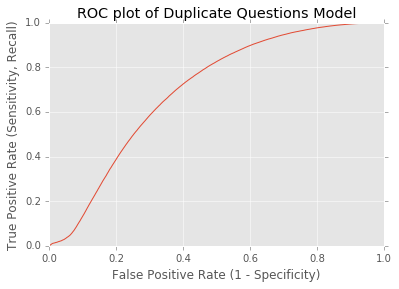

In [83]:
fpr, tpr, thresholds = roc_curve(y, doc_dist)
plt.plot(fpr, tpr) 
plt.xlabel("False Positive Rate (1 - Specificity)") 
plt.ylabel("True Positive Rate (Sensitivity, Recall)") 
plt.title("ROC plot of Duplicate Questions Model")

In [84]:
# compute auc score for average word2vec model - it's worse than tf-idf!
roc_auc_score(y, doc_dist)

0.69685295185498164

## Next try averaging using pre-trained Google News Vectors

In [86]:
# this model takes about 2 minutes to load
import gensim
model_path = "../word2vec/word2vec-C-code/data/GoogleNews-vectors-negative300.bin"
model = gensim.models.Word2Vec.load_word2vec_format(model_path, binary=True)

In [87]:
# this takes about 5 minutes to calculate
# make numpy list of normalized dot products of word vectors averages between corresponding questions 
import itertools
import numpy as np

q1_sentences = OneFileSentences('cleaned_data_bow/cleaned_q1_bow.txt')
q2_sentences = OneFileSentences('cleaned_data_bow/cleaned_q2_bow.txt')

document_distances = []

# for each sentence pair, dot the numpy vectors together to find their distance
for q1, q2 in itertools.izip(q1_sentences, q2_sentences): 
    q1_vec, q2_vec = make_question_vectors(model, q1), make_question_vectors(model, q2)
    # take normed dot product, accounting for zero vectors
    dot_prod = np.dot(q1_vec, q2_vec)
    norm = np.linalg.norm(q1_vec)*np.linalg.norm(q2_vec)
    norm_dot_prod = 0
    if dot_prod != 0: 
        norm_dot_prod = dot_prod/float(norm)
    document_distances.append(norm_dot_prod)

In [89]:
# find AUC score for this classification threshold
gnews_dist = np.array(document_distances)
y = data.duplicate.values

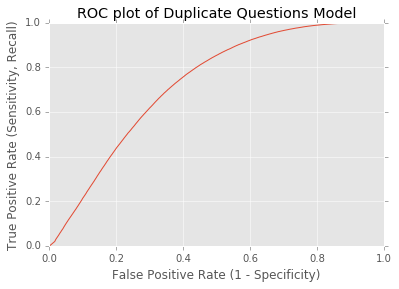

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y, gnews_dist)
plt.plot(fpr, tpr) 
plt.xlabel("False Positive Rate (1 - Specificity)") 
plt.ylabel("True Positive Rate (Sensitivity, Recall)") 
plt.title("ROC plot of Duplicate Questions Model")

In [91]:
# compute auc score for word2vec average using Googlenews model - still worse than 1-gram tf-idf model!
roc_auc_score(y, gnews_dist)

0.72593255252271049